## Population in Ireland: Where are we heading to?

### Scenario
Human capital is an important bed rock of any stable economy, a large population means more workers and customers which ultimately boosts a country’s GDP (World101, 2022).
As stated by (Wilmoth, Menozzi and Bassarsky, 2022) world population is expected to peak around 2100 at a level of almost 11 billion. (OECD and UN, 2023) both reported a country requires a birth rate of 2.1 children per woman to maintain a healthy population growth. However, Ireland has recorded a progressive decline in its birth rate since 1970 but were still within a healthy birth rate.

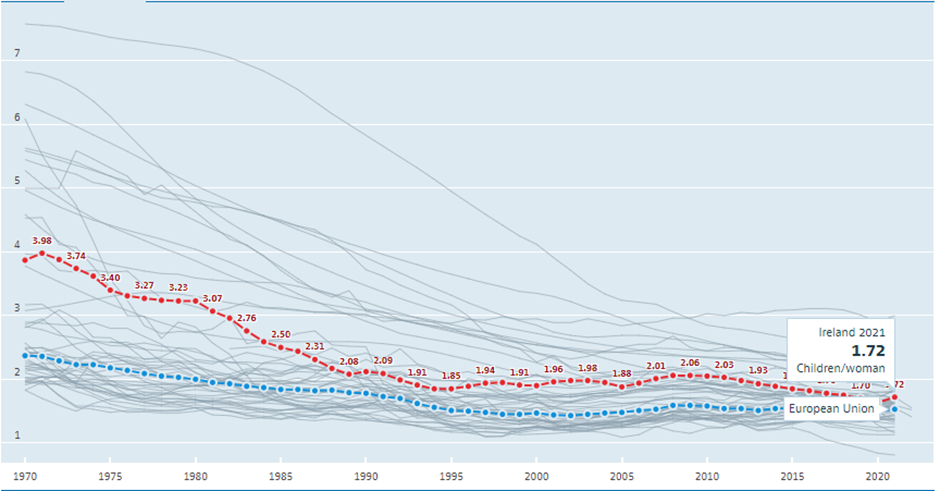

#### Data source
- Independent features: The dataset for this analysis is going to be gotten from the Central Statistics Office (CSO), Ireland. The CSO is responsible for collection, compilation, extraction and dissemination of high-quality data used for analysis of economic and social important topics.

- Dependent feature:

### Approach
At this first stage we will approach the case aiming to fit a Random Forest Regressor Machine Learning model, due to its multiple benefits like low risk of overfitting, easy to determine feature importance and not needing considerable pre-processing work, to name a few.

### Importing libraries

In [2]:
# Create a conda enviroment
conda create --n CA2_env python=3.8

# Activate conda enviroment
conda activate CA2_env

# Install pycaret
pip install pycaret

python -m ipykernel install --user --name CA2_env --display-name 'display-name'

SyntaxError: invalid syntax (4132573197.py, line 2)

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm



import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')

In [ ]:
from pycaret.time_series import *
from pycaret.time_series import TSForecastingExperiment

### Loading our independent features

In [ ]:
df = pd.read_csv('Total Births, Deaths and Marriages Registered.csv')
df.head(-5)

### Data dictionary

##### Statistic Label
- Marriages Registered
- Marriage Rate Registered per 1000 Estimated Population
- Deaths Registered
- Death Rate Registered per 1000 Estimated Population
- Deaths of Infants under 1 Year Registered per 1000 Births
- Births Registered
- Birth Rate Registered per 1000 Estimated Population
- Opposite sex marriages
- Same sex marriages
- Civil partnerships
- Births registered that were first births
- Births registered outside marriage
- Opposite sex marriage rate
- Same sex marriage rate
- Civil partnership marriage rate
- Percentage of first births registered
- Percentage of births registered outside marriage
- Average age of mothers giving birth

##### Quarter
Years from 1960 (Q1) to 2023 (Q1); each year has 4 quarters (Q1, Q2, Q3 and Q4).

##### State
- State

##### UNIT
These represents the metric of the next feature (VALUE).
- Number
- %

##### VALUE
Values regarding the Statistic Label feature.

### EDA and data preparation

In [ ]:
df.info() # Check the shape and and types of our data

In [ ]:
df.isnull().mean()*100 # Porcentage of missing data

In [ ]:
df['Statistic Label'].unique() # Check the categories in our Statistic Label.

Let's confirm that our 'State' feature only has 1 category, and in that case we can drop the feature due that it doesn't add any value to our analysis.

In [ ]:
df['State'].unique()

In [ ]:
df.drop(columns='State', inplace=True) # Dropping the 'State' feature.
df.head()

Since we are looking for values in numbers and not represented in percentages, we will drop all the rows that has % in our 'UNIT' feature, after performing this task, we can now drop the 'UNIT' feature because we know that we only have values represented in numbers.

In [ ]:
df['UNIT'].unique()

In [ ]:
df = df[df['UNIT'].str.contains('%')==False]
df['UNIT'].unique()

In [ ]:
df.drop(columns='UNIT', inplace=True)
df.head()

Standardize in lower case letters in a new feature our 'Statistic Label' feature to manage all the categories easier.

In [ ]:
df['label_lc'] = df['Statistic Label'].apply(lambda x: ' '.join(x.lower() for x in x.split())) # put everything in lower case
df[['label_lc']].head()

Since we are analysing the population change per year, we do not need the values per quater, therefore we will remove Q1, Q2, Q3 and Q4 from the Quater column and then we will be able to asign the column as a integer (whole numbers).


In [ ]:
df.rename(columns={"Quarter": "year"}, inplace=True)
df.rename(columns={"VALUE": "value"}, inplace=True)

In [ ]:
df['year'] = df['year'].str[:-2] # Remove the 2 last characters
df['year']

In [ ]:
df['year'] = df['year'].astype(int) # Assign Quarter column as a type integer
df.dtypes

Due to we have a dataset which years are divided per quarter, we need to sum each quarter value into one single row, then, we can remove every category in our 'label_lc' feature that we do not need, we only require the overall value of births, deaths and marriages.

In [ ]:
df_group = df.groupby(['year','label_lc'])['value'].sum()
df_group.head(20)

In [ ]:
df = df[df['label_lc'].str.contains('average age of mothers giving birth')==False]
df = df[df['label_lc'].str.contains('births registered outside marriage')==False]
df = df[df['label_lc'].str.contains('births registered that were first births')==False]
df = df[df['label_lc'].str.contains('civil partnerships')==False]
df = df[df['label_lc'].str.contains('opposite sex marriages')==False]
df = df[df['label_lc'].str.contains('same sex marriages')==False]
df = df[df['label_lc'].str.contains('birth rate registered per 1000 estimated population')==False]
df = df[df['label_lc'].str.contains('death rate registered per 1000 estimated population')==False]
df = df[df['label_lc'].str.contains('deaths of infants under 1 year registered per 1000 births')==False]
df = df[df['label_lc'].str.contains('marriage rate registered per 1000 estimated population')==False]

df['label_lc'].unique()

Assign VALUE column as a type integer, since a birth or death can only be an integer.

In [ ]:
df['value'] = df['value'].astype(int)
df.dtypes

Now we can cut our dataset by removing the year 2023, owing to the fact that we are analysing from 1960 to 2022.

In [ ]:
df = df.query('year != 2023')
df['year'].unique()

In [ ]:
df.head()

Remove the feature 'Statistic Label' since we already have a lower case feature with the same data.

In [ ]:
df.drop(columns='Statistic Label', inplace=True)
df.head()

In [ ]:
df_group = df.groupby(['year','label_lc'], as_index=False)['value'].sum()
df_group.head(20)

In [ ]:
df_group['label_lc'].replace('births registered','births_registered', inplace=True)
df_group['label_lc'].replace('deaths registered','deaths_registered', inplace=True)
df_group['label_lc'].replace('marriages registered','marriages_registered', inplace=True)
df_group.head()

In [ ]:
df_group.info()

In [ ]:
df_group.isnull().mean()*100 # Porcentage of missing data

At this point of our analysis, we will need to split our 'label_lc' categories into different datasets with the goal of making each category a feature of its own in a new dataset.

In [ ]:
df_births = pd.DataFrame() # Create an empty data frame to store the births values
df_deaths = pd.DataFrame() # Create an empty data frame to store the deaths values
df_marriages = pd.DataFrame() # Create an empty data frame to store the marriages values

In [ ]:
df_births = df_group.loc[df_group['label_lc'] == 'births_registered']
df_deaths = df_group.loc[df_group['label_lc'] == 'deaths_registered']
df_marriages = df_group.loc[df_group['label_lc'] == 'marriages_registered']

In [ ]:
df_births.rename(columns={"value": "births"}, inplace=True)
df_births.head()

In [ ]:
df_births.drop(columns='label_lc', inplace=True) # drop the label column since we already have our 'births' feature
df_births.head()

In [ ]:
df_deaths.rename(columns={"value": "deaths"}, inplace=True)
df_deaths.head()

In [ ]:
df_deaths.drop(columns='label_lc', inplace=True) # drop the label column since we already have our 'deaths' feature
df_deaths.head()

In [ ]:
df_marriages.rename(columns={"value": "marriages"}, inplace=True)
df_marriages.head()

In [ ]:
df_marriages.drop(columns='label_lc', inplace=True) # drop the label column since we already have our 'marriages' feature
df_marriages.head()

In [ ]:
df_new1 = pd.merge(df_births, df_deaths, how='inner', on='year')
df_new1.head()

In [ ]:
df_new = pd.merge(df_new1, df_marriages, how='inner', on='year')
df_new.head()

In [ ]:
df_new.shape

In [ ]:
df_new.info()

In [ ]:
df_new.describe()

In [ ]:
df_new.isnull().mean()*100 # Porcentage of missing data

### Loading our dependent feature

In [ ]:
# Source: https://population.un.org/wpp/Download/ (United Nations)
df_target = pd.read_csv('population-with-un-projections.csv')
df_target.head()

### Data dictionary

##### Entity
Countries.

##### Code
Abbreviation of the countries.

##### Year
Years of the values.

##### Population - Sex: all - Age: all - Variant: estimates
Values of the population.

##### Population - Sex: all - Age: all - Variant: medium
Projections values of the population.


In [ ]:
df_target['Entity'].unique()

In [ ]:
df_target['Code'].unique()

As we know, the abbreviation for IRELAND is IRL, with this we can extract the desire data.

In [ ]:
df_target = df_target[df_target['Code'].str.contains('IRL')==True]
df_target.head(5)

In [ ]:
df_target.describe()

In [ ]:
df_target.info()

In [ ]:
df_target.isnull().mean()*100 # Porcentage of missing data

We need to cut our dataset our target dataset because it goes from 1950 to 2100 and our analysis is from 1960 to 2022, then we require to have all the population values in the same feature.

In [ ]:
df_target = df_target[df_target['Year'] >= 1960]
df_target = df_target[df_target['Year'] <= 2022]
df_target = df_target.drop(columns =['Entity','Code'], axis=1)
df_target.columns= ['year', 'pop', 'pop1']
df_target.head()

In [ ]:
df_target.fillna(0,inplace=True)
df_target['population'] = df_target['pop']+df_target['pop1']
df_target['population'] = df_target['population'].astype('int')
df_target.head()

In [ ]:
df_target = df_target.drop(columns =['pop','pop1'], axis=1)
df_target.shape

In [ ]:
df_target.info()

In [ ]:
df_target.describe()

In [ ]:
df_target
df_target.head(10)

At this point, we have our target dataset and our independent features dataset, we can now merge both to be able to proceed with further analysis and with our Machine Learning model.

In [ ]:
df_new = pd.merge(df_new, df_target, how='inner', on='year')
df_new.head()

In [ ]:
df_new.isnull().mean()*100 # Porcentage of missing data

In [ ]:
df_new.shape

In [ ]:
df_new.info()

In [ ]:
df_new.describe()

In [ ]:
df_new['population'].describe().apply('{0:.2f}'.format) # Descriptive statistics formatted for a better understanding

In [ ]:
sns.scatterplot(data=df_new, x='year', y='population')

In [ ]:
sns.scatterplot(data=df_new.iloc[:,1:4])

In [ ]:
sns.scatterplot(data=df_new.iloc[:,1:3])

In [ ]:
sns.scatterplot(data=df_new.iloc[:,[1,3]])

In [ ]:
sns.scatterplot(data=df_new, x='year', y='births')

In [ ]:
sns.scatterplot(data=df_new, x='year', y='deaths')

In [ ]:
sns.scatterplot(data=df_new, x='year', y='marriages')

### Machine Learning models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score


X = df_new.iloc[:,0:4]
y = df_new['population']

In [ ]:
X.shape, y.shape

###  Random Forest Regressor:
To perform a Hyperparameter tuning we can use the Grid Search library to help us iterate multiple values of parameters through the Machine Learning model.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
tuning_grid = {
    'n_estimators': [10, 20, 30, 40, 50],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 5, 7, 9],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_leaf_nodes': [3, 4, 5, 6, 7, 8, 9]  
}

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.10, random_state=4)
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

In [ ]:
grid_search1 = GridSearchCV(RandomForestRegressor(), 
                           param_grid=tuning_grid, scoring='r2') 
grid_search1.fit(X1_train, y1_train) 
print(grid_search1.best_estimator_) 

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.20, random_state=4)
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

In [ ]:
grid_search2 = GridSearchCV(RandomForestRegressor(), 
                           param_grid=tuning_grid, scoring='r2') 
grid_search2.fit(X2_train, y2_train) 
print(grid_search2.best_estimator_) 

In [ ]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X, y, test_size=0.30, random_state=4)
X3_train.shape, X3_test.shape, y3_train.shape, y3_test.shape

In [ ]:
grid_search3 = GridSearchCV(RandomForestRegressor(), 
                           param_grid=tuning_grid, scoring='r2') 
grid_search3.fit(X3_train, y3_train) 
print(grid_search3.best_estimator_) 

In [ ]:
print('Best Hyperparameters (90% training):',grid_search1.best_params_)
print('Best Score (90% training):',grid_search1.best_score_)
print('Best Hyperparameters (80% training):',grid_search2.best_params_)
print('Best Score (80% training):',grid_search2.best_score_)
print('Best Hyperparameters (70% training):',grid_search3.best_params_)
print('Best Score (70% training):',grid_search3.best_score_)

### R2 scores comparison (Training v Testing):

In [ ]:
RF1 = RandomForestRegressor(max_depth=5, max_features=None, max_leaf_nodes=8, min_samples_leaf=1, n_estimators=20)
RF1.fit(X1_train, y1_train)
train1_pred = RF1.predict(X1_train)
y1_pred = RF1.predict(X1_test)
train1_result = r2_score(y1_train, train1_pred)
test1_result = r2_score(y1_test, y1_pred)
print('r2_score result (training)(90% training):',train1_result)
print('r2_score result (testing)(90% training):',test1_result)

In [ ]:
RF2 = RandomForestRegressor(max_depth=5, max_features=None, max_leaf_nodes=8, min_samples_leaf=1, n_estimators=50)
RF2.fit(X2_train, y2_train)
train2_pred = RF2.predict(X2_train)
y2_pred = RF2.predict(X2_test)
train2_result = r2_score(y2_train, train2_pred)
test2_result = r2_score(y2_test, y2_pred)
print('r2_score result (training)(80% training):',train2_result)
print('r2_score result (testing)(80% training):',test2_result)

In [ ]:
RF3 = RandomForestRegressor(max_depth=7, max_features=None, max_leaf_nodes=9, min_samples_leaf=1, n_estimators=30)
RF3.fit(X3_train, y3_train)
train3_pred = RF3.predict(X3_train)
y3_pred = RF3.predict(X3_test)
train3_result = r2_score(y3_train, train3_pred)
test3_result = r2_score(y3_test, y3_pred)
print('r2_score result (training)(70% training):',train3_result)
print('r2_score result (testing)(70% training):',test3_result)

### Feature importances:

90% training

In [ ]:
features1 = pd.DataFrame(RF1.feature_importances_).T
features1.columns = X.columns
features1

80% training

In [ ]:
features2 = pd.DataFrame(RF2.feature_importances_).T
features2.columns = X.columns
features2

70% training

In [ ]:
features3 = pd.DataFrame(RF3.feature_importances_).T
features3.columns = X.columns
features3

In our RandomForestRegressor 3, which has a 70% of training data, we can observe that the 'deaths' feature has a higher importance than in the other 2 models, this is particularly relevant knowing that since 2005-2006 (in our 'years-deaths' plot) the number of deaths in Ireland are rising and reaching all time highs in recent years.

In [ ]:
features3.plot(kind='bar', title='RandomForestRegressor with 70% of data as training');

### Second approach

Following our initial understanding of our data and feature importance using the Random Forest Regressor algorithm, we will compare multiple machine learning models.

In this new approach, considering that our data type is time series, using our target feature (Population) we will make sure that our data is stationary before training our models.

Time Series is a way of stydying the characteristics of the response variable concerning time as the independent variable. To estimate the target variable in forecasting, we use the time variable as the reference point (Pandian, 2021).

In [ ]:
# Function to plot and check our time series data
def plot_time_series(xt, nlag = 100, fig_size = (10,8)):
    if not isinstance(xt, pd.Series):
        xt = pd.Series(xt)
    plt.figure(figsize = fig_size)
    layout = (2,2)

    ax_xt = plt.subplot2grid(layout, (0,0), colspan = 2) # It will take 2 column spaces
    ax_acf = plt.subplot2grid(layout, (1,0))
    ax_pacf = plt.subplot2grid(layout, (1,1))

    xt.plot(ax = ax_xt)
    ax_xt.set_title('Time Series', fontdict = {'fontsize':18})
    plot_acf(xt, lags = 50, ax = ax_acf)
    plot_pacf(xt, lags = 29, ax = ax_pacf)
    plt.tight_layout() # Adjust the padding between and around subplots
    return None

In [ ]:
df_new

In [ ]:
# We will put our 'year' feature as index to perform the time series analysis
df_new['year'] = pd.to_datetime(df_new['year'], format = '%Y')
df_new.index = df_new['year']
df_new.drop('year', axis = 1, inplace = True) # Since we now have our index based on the year, we do not longer need our 'year' feature

In [ ]:
df_new

Now we need to visualise the Autocorrelation and Partial Autorcorrelation of our data.

Autocorrelation (ACF): Calculation of the correlation of the time series observations with values of the same series, but at previous times.

Partial Autocorrelation (PACF): Summarises the relationship between an observation in a time series with observations at previous time steps, but the relationships of intervening observations are removed.

(Marv, 2021)

In [ ]:
plot_time_series(df_new['population'], nlag = 100)

From these plots, we are looking at the point outside the blue shadow, that means that they have statistical significance, that indicates that an observed relationship is unlikely to be due to chance.

Let's see if our data is stationary or not by performing a Dickey Fuller test.

In [ ]:
fuller_result = adfuller(df_new.population.to_list())
print('ADF Statistic %f' % fuller_result[0])
print('p-value %f' % fuller_result[1])

Since we got a p-value of almost 1, we can say that our data is not stationary, therefore, we will use te differencin method to make it stationary.

In [ ]:
first_differencing = df_new['population'].diff().dropna()

In [ ]:
fuller_result = adfuller(first_differencing)

print('ADF Statistic: %f' % fuller_result[0])
print('p-value: %f' % fuller_result[1])

As we can see, our p-value is more than 0.05, we can say that our data is not stationary, hence, we will need to perform the second-order differencing method.

In [ ]:
second_differencing = df_new['population'].diff().diff().dropna()

In [ ]:
plot_time_series(second_differencing, nlag = 100)
fuller_result = adfuller(second_differencing)

print('ADF Statistic: %f' % fuller_result[0])
print('p-value: %f' % fuller_result[1])

After performing the second-order differencing method we got a p-value of 0.0034, with that we can conclude that our data is now stationary.

In [ ]:
fig, ax = plt.subplots(2, sharex = True);
fig.set_size_inches(10,4);

df_new['population'].plot(ax = ax[0], color = 'b');
ax[0].set_title('Population');

second_differencing.plot(ax = ax[1], color = 'g');
ax[1].set_title('Population after second-order differencing method');

In order to find the best machine learning model for our data, we will use the pycaret library to compare multiple algorithms.

In [ ]:
py_time = TSForecastingExperiment()
model_comparison = 